### CatBoost classification model for predicting COVID-19 severity using single-cell RNA sequencing data

## Import libaries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import collections
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import f1_score

## Load data

### Load testing data

In [2]:
# Load testing data (3 patients)
X_test = pd.read_csv('split_data/test-data.csv')
y_test = pd.read_csv('split_data/test-data-labels.csv')

In [3]:
# Convert the text labels to numerical labels
# In this case, we will say 0=normal, 1=mild, 2=severe
y_test['type']=y_test['type'].replace('Normal',0)
y_test['type']=y_test['type'].replace('Mild', 1)
y_test['type']=y_test['type'].replace('Severe', 2)

In [4]:
# Save feature names before turning dataframe into numpy array 
feature_names = list(X_test.drop(columns=['Unnamed: 0']).columns)

In [5]:
# Drop unnecessary columns
X_test = np.array(X_test.drop(columns=['Unnamed: 0'])) # dataset is all the data expect for the first column containing the identifier information
y_test = np.array(y_test.drop(columns=['Unnamed: 0']))
y_test = np.reshape(y_test, (y_test.shape[0],)) # reshape the data to be (n,) instead of (n,1)

In [6]:
# Print shapes of testing dataset 
print("Testing data size:", X_test.shape)
print("Testing labels size:", y_test.shape)

Testing data size: (5608, 1999)
Testing labels size: (5608,)


### Load training data 

In [7]:
# Load training data (one patient at a time)
num_folds = 10
X_train = [[] for x in range(num_folds)] # make list of arrays to hold X data for each patient
y_train = [[] for x in range(num_folds)] # make list of arrays to hold y data for each patient
for i in range(num_folds):
    X_filename = 'split_data/train-data_' + str(i+1) + '.csv'
    y_filename = 'split_data/train-data-labels_' + str(i+1) + '.csv'

    X_train_temp = pd.read_csv(X_filename)
    y_train_temp = pd.read_csv(y_filename)

    # Convert the text labels to numerical labels
    # In this case, we will say 0=normal, 1=mild, 2=severe
    y_train_temp['type'] = y_train_temp['type'].replace('Normal', 0)
    y_train_temp['type'] = y_train_temp['type'].replace('Mild', 1)
    y_train_temp['type'] = y_train_temp['type'].replace('Severe', 2)

    # Drop unnecessary columns
    X_train_temp = np.array(X_train_temp.drop(columns=['Unnamed: 0']))  # dataset is all the data expect for the first column containing the identifier information
    y_train_temp = np.array(y_train_temp.drop(columns=['Unnamed: 0']))
    y_train_temp = np.reshape(y_train_temp, (y_train_temp.shape[0],))  # reshape the data to be (n,) instead of (n,1)

    X_train[i] = X_train_temp
    y_train[i] = y_train_temp

In [8]:
# Print shapes of training dataset
for i in range(num_folds): 
    print("Patient " + str(i+1) + " data size:", X_train[i].shape)
    print("Patient " + str(i+1) + " label size:", y_train[i].shape)
    print('\n')

Patient 1 data size: (377, 1999)
Patient 1 label size: (377,)


Patient 2 data size: (86, 1999)
Patient 2 label size: (86,)


Patient 3 data size: (383, 1999)
Patient 3 label size: (383,)


Patient 4 data size: (3858, 1999)
Patient 4 label size: (3858,)


Patient 5 data size: (347, 1999)
Patient 5 label size: (347,)


Patient 6 data size: (4818, 1999)
Patient 6 label size: (4818,)


Patient 7 data size: (5253, 1999)
Patient 7 label size: (5253,)


Patient 8 data size: (1672, 1999)
Patient 8 label size: (1672,)


Patient 9 data size: (224, 1999)
Patient 9 label size: (224,)


Patient 10 data size: (563, 1999)
Patient 10 label size: (563,)




# Training cell-level classification

## 1. Baseline classifier

### Train and validate model

In [9]:
# Create lists to store results from each fold 
f1_values = []
feature_importance_values = []

# Perform 10-fold cross validation
for i in range(num_folds):
    print("Fold", i) 
    X_cv_test = X_train[i]
    y_cv_test = y_train[i]
    print("Testing data size:", X_cv_test.shape)
    print("Testing label size:", y_cv_test.shape) 
    
    X_cv_train = X_train[:i] + X_train[i+1 :]
    X_cv_train = np.concatenate(X_cv_train, axis=0) # convert list of np arrays to single np array
    y_cv_train = y_train[:i] + y_train[i+1 :]
    y_cv_train = np.concatenate(y_cv_train, axis=0)
    print("Training data size:", X_cv_train.shape)
    print("Training label size:", y_cv_train.shape) 

    # Build random forest model with whatever hyperparameters you want to use
    clf = CatBoostClassifier(iterations=300, eval_metric='AUC', task_type="GPU", logging_level='Silent', random_seed=0)
    clf.fit(X_cv_train, y_cv_train)  # train the model using cross validation training set (9 patients)
    cv_pred = clf.predict(X_cv_test)  # predict using cross validation testing set (1 patient)
    
    f1 = f1_score(y_cv_test, cv_pred, average='weighted')
    f1_values.append(f1)
    print("f1 score:", f1)
     
    # Print confusion matrix
    print("Confusion Matrix") 
    print(confusion_matrix(y_cv_test, cv_pred))

    print("\n") 
    
    # Save feature importance values from each fold 
    feature_importance_values.append(clf.feature_importances_)


Fold 0
Testing data size: (377, 1999)
Testing label size: (377,)
Training data size: (17204, 1999)
Training label size: (17204,)


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


f1 score: 1.0
Confusion Matrix
[[377]]


Fold 1
Testing data size: (86, 1999)
Testing label size: (86,)
Training data size: (17495, 1999)
Training label size: (17495,)


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


f1 score: 0.7259259259259259
Confusion Matrix
[[ 0  0]
 [37 49]]


Fold 2
Testing data size: (383, 1999)
Testing label size: (383,)
Training data size: (17198, 1999)
Training label size: (17198,)


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


f1 score: 0.9986928104575163
Confusion Matrix
[[  0   0]
 [  1 382]]


Fold 3
Testing data size: (3858, 1999)
Testing label size: (3858,)
Training data size: (13723, 1999)
Training label size: (13723,)


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


f1 score: 0.999611046285492
Confusion Matrix
[[   0    0    0]
 [   0    0    0]
 [   2    1 3855]]


Fold 4
Testing data size: (347, 1999)
Testing label size: (347,)
Training data size: (17234, 1999)
Training label size: (17234,)


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


f1 score: 1.0
Confusion Matrix
[[347]]


Fold 5
Testing data size: (4818, 1999)
Testing label size: (4818,)
Training data size: (12763, 1999)
Training label size: (12763,)


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


f1 score: 0.9289763254418137
Confusion Matrix
[[4179  639]
 [   0    0]]


Fold 6
Testing data size: (5253, 1999)
Testing label size: (5253,)
Training data size: (12328, 1999)
Training label size: (12328,)


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


f1 score: 0.9995238548709648
Confusion Matrix
[[5248    4    1]
 [   0    0    0]
 [   0    0    0]]


Fold 7
Testing data size: (1672, 1999)
Testing label size: (1672,)
Training data size: (15909, 1999)
Training label size: (15909,)


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


f1 score: 0.10645526613816533
Confusion Matrix
[[   0    0    0]
 [1573   94    5]
 [   0    0    0]]


Fold 8
Testing data size: (224, 1999)
Testing label size: (224,)
Training data size: (17357, 1999)
Training label size: (17357,)


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


f1 score: 1.0
Confusion Matrix
[[224]]


Fold 9
Testing data size: (563, 1999)
Testing label size: (563,)
Training data size: (17018, 1999)
Training label size: (17018,)


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


f1 score: 0.7734204793028323
Confusion Matrix
[[355 208]
 [  0   0]]




### Calculate results

In [10]:
# Calculate final performance metric
f1_final = np.mean(f1_values)
print("Final f1 score:", f1_final)

Final f1 score: 0.8532605708422711


In [11]:
# Calculate and plot final feature importance scores
feature_importance_final = np.mean(feature_importance_values, axis=0)
feature_imp = pd.Series(feature_importance_final, index=feature_names).sort_values(ascending=False) # sort features by their feature importance score, in descending order
top_feature_imp = feature_imp.head(15)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


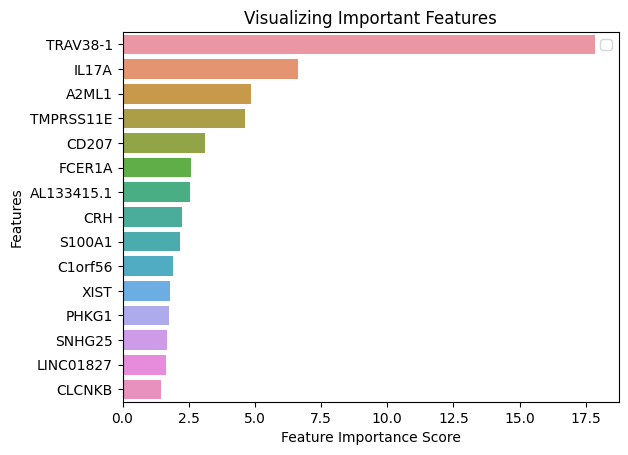

In [12]:
# Plot feature importance
import seaborn as sns
# %matplotlib inline
sns.barplot(x=top_feature_imp, y=top_feature_imp.index) # creating a bar plot of feature importance

# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

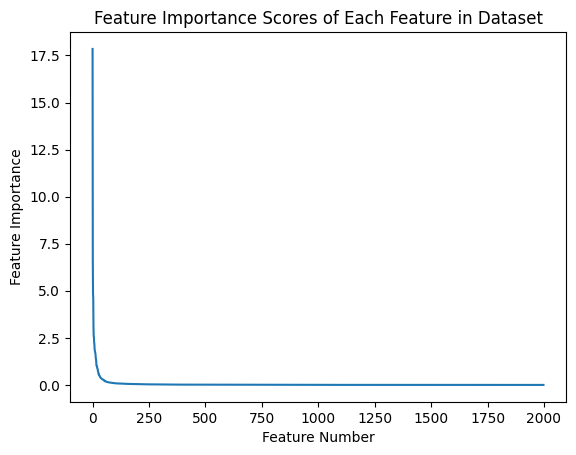

In [13]:
# Plot feature importance scores 
numbers = np.arange(len(feature_imp))
plt.plot(numbers, feature_imp)
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance")
plt.title("Feature Importance Scores of Each Feature in Dataset")
plt.show()

In [14]:
# Find exact elbow of the plot above 
# %pip install kneed
from kneed import KneeLocator
kn = KneeLocator(numbers, feature_imp, curve='convex', direction='decreasing')
print("Elbow point:", kn.knee)

Elbow point: 42


## 2. Classifier trained on top n features

In [15]:
# Get features to retain
df = pd.read_csv('split_data/test-data.csv')
df = df.drop(columns=['Unnamed: 0'])
keep_data = feature_imp.head(kn.knee)
keep_names = list(keep_data.index)  # get names of the top n features to keep
index = df.columns.get_indexer(keep_names)  # find index of the top n features in the dataset

### Train and validate model

In [16]:
f1_select_values = []
feature_importance_select_values = []

for i in range(num_folds):
    print("Fold", i) 

    # Cross validation testing data
    X_select_cv_test = X_train[i]
    y_select_cv_test = y_train[i]
    X_select_cv_test = X_select_cv_test[:, index] # retain only the top n features in the data
    print("Testing data size:", X_select_cv_test.shape)
    print("Testing label size:", y_select_cv_test.shape) 

    # Cross validation training data
    X_select_cv_train = X_train[:i] + X_train[i+1 :]
    X_select_cv_train = np.concatenate(X_select_cv_train, axis=0) # convert list of np arrays to single np array
    X_select_cv_train = X_select_cv_train[:, index]
    y_select_cv_train = y_train[:i] + y_train[i+1 :]
    y_select_cv_train = np.concatenate(y_select_cv_train, axis=0)
    print("Training data size:", X_select_cv_train.shape)
    print("Training label size:", y_select_cv_train.shape) 

    # Build model
    clf_select = CatBoostClassifier(iterations=800, eval_metric='AUC', task_type="CPU", logging_level='Silent', random_seed=0)
    clf_select.fit(X_select_cv_train, y_select_cv_train)  # train the model using cross validation training set (9 patients)
    cv_select_pred = clf_select.predict(X_select_cv_test)  # predict using cross validation testing set (1 patient)

    # Calculate f1 score 
    f1_select = f1_score(y_select_cv_test, cv_select_pred, average='weighted')
    f1_select_values.append(f1_select)
    print("f1 score:", f1_select) 
    feature_importance_select_values.append(clf_select.feature_importances_)
        
    # Print confusion matrix
    print("Confusion Matrix") 
    print(confusion_matrix(y_select_cv_test, cv_select_pred))

    print("\n") 

Fold 0
Testing data size: (377, 42)
Testing label size: (377,)
Training data size: (17204, 42)
Training label size: (17204,)
f1 score: 1.0
Confusion Matrix
[[377]]


Fold 1
Testing data size: (86, 42)
Testing label size: (86,)
Training data size: (17495, 42)
Training label size: (17495,)
f1 score: 0.7972027972027972
Confusion Matrix
[[ 0  0]
 [29 57]]


Fold 2
Testing data size: (383, 42)
Testing label size: (383,)
Training data size: (17198, 42)
Training label size: (17198,)
f1 score: 0.9986928104575163
Confusion Matrix
[[  0   0]
 [  1 382]]


Fold 3
Testing data size: (3858, 42)
Testing label size: (3858,)
Training data size: (13723, 42)
Training label size: (13723,)
f1 score: 0.9997407311381903
Confusion Matrix
[[   0    0]
 [   2 3856]]


Fold 4
Testing data size: (347, 42)
Testing label size: (347,)
Training data size: (17234, 42)
Training label size: (17234,)
f1 score: 1.0
Confusion Matrix
[[347]]


Fold 5
Testing data size: (4818, 42)
Testing label size: (4818,)
Training data s

### Calculate results 

In [17]:
# Calculate final performance metric
f1_select_final = np.mean(f1_select_values)
print("Final f1 score:", f1_select_final) 

Final f1 score: 0.9205086835610208


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


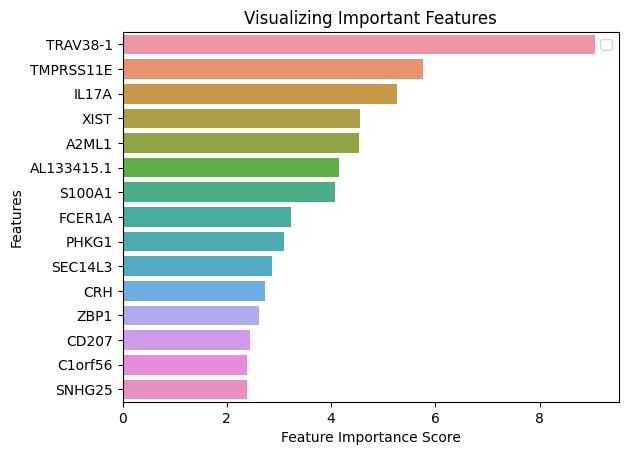

In [18]:
# Calculate and plot final feature importance scores
feature_importance_select_final = np.mean(feature_importance_select_values, axis=0)
feature_imp_select = pd.Series(feature_importance_select_final, index=keep_names).sort_values(ascending=False) # sort features by their feature importance score, in descending order
top_feature_imp_select = feature_imp_select.head(15)

# Plot feature importance
import seaborn as sns
# %matplotlib inline
sns.barplot(x=top_feature_imp_select, y=top_feature_imp_select.index) # creating a bar plot of feature importance

# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## Final cell-level classifier 
Best cell level classifier- catboost trained on top 39 features

Evaluate performance on on entire training set (all 10 patients at once). Don't do cross validation. Run training on all 10 patients at once.

In [19]:
# Merge data for all patients into one training set instead of 10 indiviual ones 
X_train_total = np.concatenate(X_train, axis=0)
X_train_total = X_train_total[:, index]
y_train_total = np.concatenate(y_train, axis=0)
print("Training data size:", X_train_total.shape)
print("Training label size:", y_train_total.shape)

Training data size: (17581, 42)
Training label size: (17581,)


In [20]:
# Perform training 
clf_final = CatBoostClassifier(iterations=1400, eval_metric='AUC', task_type="CPU", logging_level='Silent', random_seed=0)
clf_final.fit(X_train_total, y_train_total)

### Feature Importance Scores of Final Classifier

In [21]:
data = pd.read_csv('covid-selected-data.csv') # data 
print(data.shape)

(23189, 2000)


In [22]:
# Keep only n=kn.knee number of features 
# This is equal to removing the bottom (1999-kn.knee) features 
remove_data = feature_imp.tail(1999-kn.knee)
remove_names = list(remove_data.index)
select_data = data.drop(labels=remove_names, axis=1)
print(select_data.shape)

(23189, 43)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


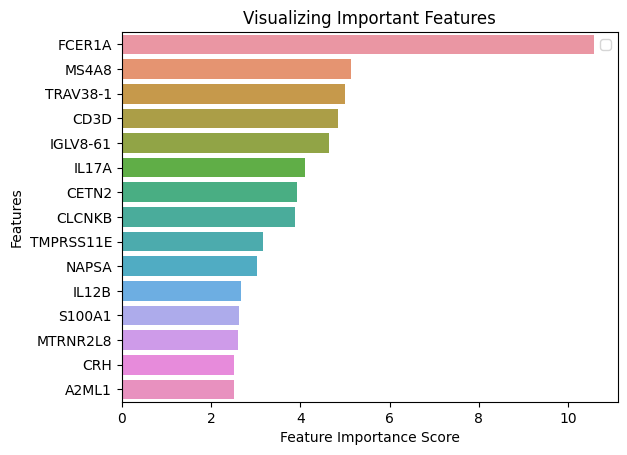

In [61]:
# Find feature importance
feature_names_select = list(select_data.drop(columns=['Unnamed: 0']).columns)
feature_imp_select = pd.Series(clf_final.feature_importances_, index=feature_names_select).sort_values(ascending=False)
top_feature_imp_select = feature_imp_select.head(15)

# Plot feature importance
import seaborn as sns
# %matplotlib inline
sns.barplot(x=top_feature_imp_select, y=top_feature_imp_select.index) # creating a bar plot of feature importance

# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.savefig('feature-imp.png', format='png', bbox_inches='tight', dpi=600)
plt.show()

## External Validation

In [24]:
X_test_trim = X_test[:, index]
y_pred = clf_final.predict(X_test_trim) # predict one patient at a time, change clf to something else if needed

In [25]:
# Calculate final performance metric
f1_test = f1_score(y_test, y_pred, labels=None, pos_label=1, average='weighted', sample_weight=None, zero_division='warn')
print("Final f1 score:", f1_test)

Final f1 score: 0.9820096514892722


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


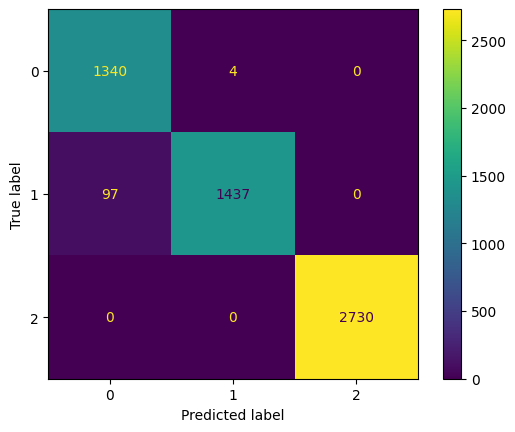

In [ ]:
plot_confusion_matrix(clf_final, X_test_trim, y_test)
plt.savefig('confusion-matrix.png', format='png', bbox_inches='tight', dpi=600)
plt.show()

## Explainable AI SHAP

In [27]:
import shap
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.TreeExplainer(clf_final)
shap_values = explainer.shap_values(X_test_trim)

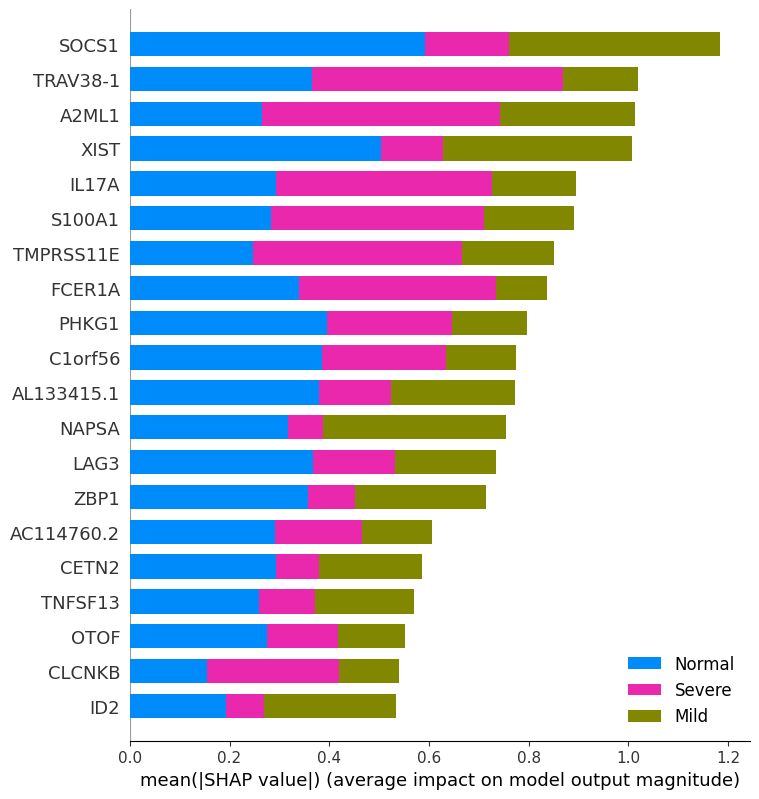

In [30]:
# Average Impact on Model Output for each label type
shap.summary_plot(shap_values, feature_names=keep_names, plot_type="bar", class_names=['Normal', 'Mild', 'Severe'])

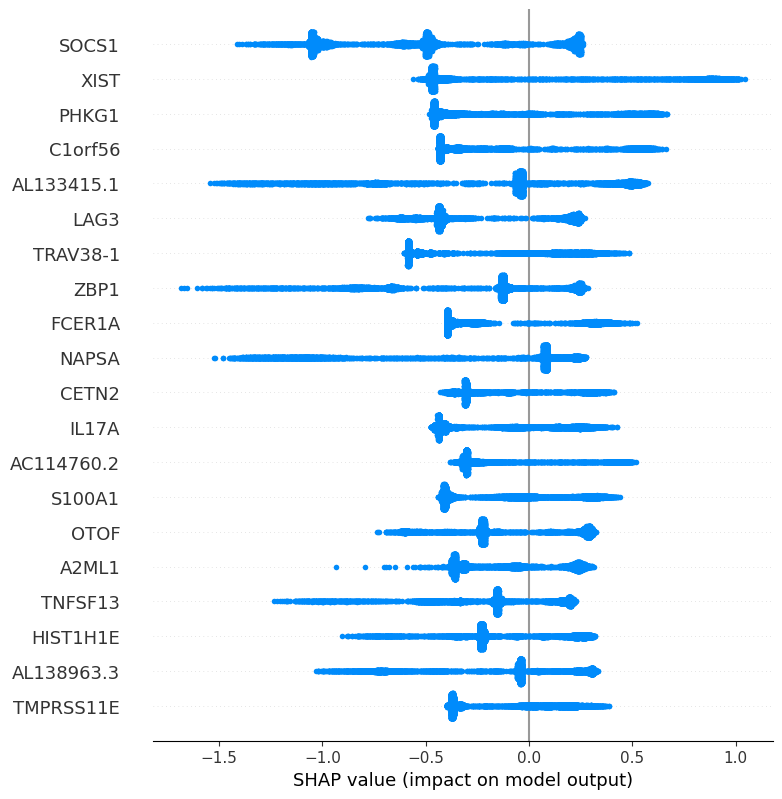

In [31]:
# Impact on Model Output for type: Normal
shap.summary_plot(shap_values[0], feature_names=keep_names)

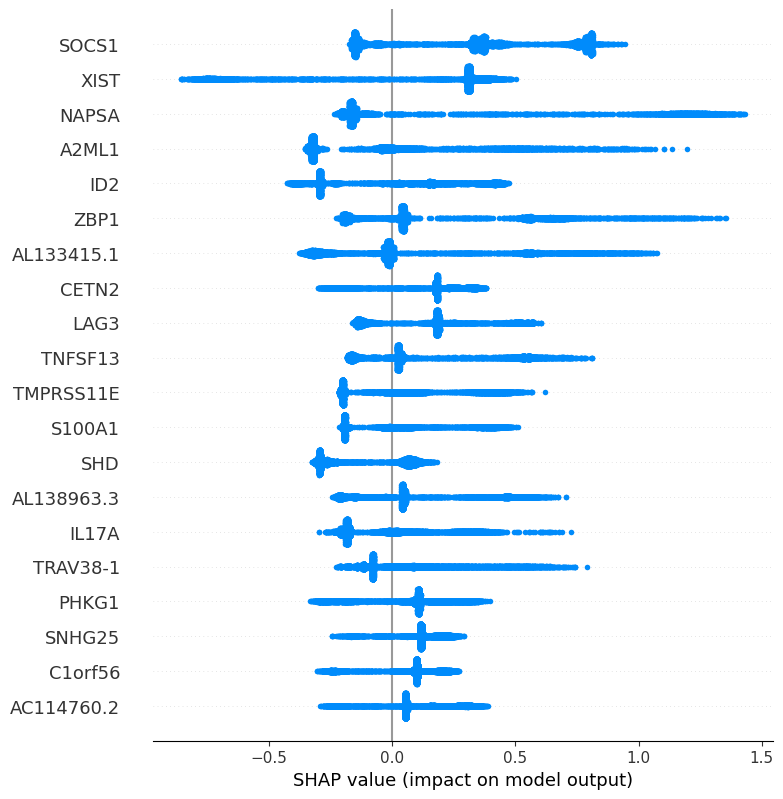

In [32]:
# Impact on Model Output for type: Mild
shap.summary_plot(shap_values[1], feature_names=keep_names)

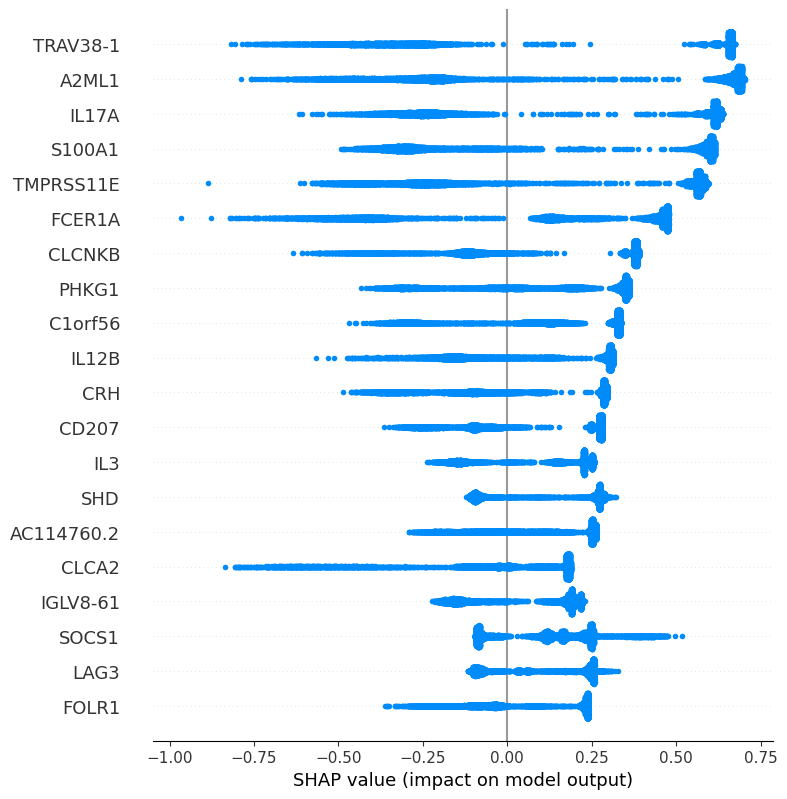

In [33]:
# Impact on Model Output for type: Severe
shap.summary_plot(shap_values[2], feature_names=keep_names)

# Training patient level classification 
Input data is output of cell-level classification training

In [34]:
# Make predictions for each patient
predictions = [[] for x in range(num_folds)]
for i in range(num_folds):
    pred = clf_final.predict(X_train[i][:, index]) # predict one patient at a time, change clf to something else if needed
    predictions[i] = pred

In [35]:
# Insert data into second classifier 
patient_data = np.zeros((len(predictions), 3)) # output from classifier 1, to be inputted into classifier 2
for i in range(len(predictions)):
    N = len(predictions[i])
    freq = collections.Counter(predictions[i].reshape(1,-1)[0])
    for (key,value) in freq.items():
        patient_data[i][key] = value/N # get percentage of cells classified into each category 

In [36]:
df = pd.DataFrame(patient_data)
df

,0,1,2
0,0.0,0.0,1.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,0.0,1.0,0.0
8,0.0,0.0,1.0
9,1.0,0.0,0.0


In [37]:
# Create labels to insert into second classifier
patient_labels = []
for i in range(num_folds):
    patient_labels.append(y_train[i][0])
patient_labels

[2, 1, 2, 2, 2, 0, 0, 1, 2, 0]

### Train and validate model

In [38]:
# Build patient level classifier with random forest
# Perform LOO cross validation with each of the 10 patients
accuracy_values_patient = []
for i in range(num_folds):
    print("Fold", i)
    X_cv_test_patient = patient_data[i].reshape(1,-1) # features to input (percentage of cells in each class + total number of cells)
    y_cv_test_patient = patient_labels[i] # ground truth label
    print("Testing data size:", X_cv_test_patient.shape)
    print("Testing label size:", y_cv_test_patient.shape)

    X_cv_train_patient = np.delete(patient_data, i, axis=0)
    y_cv_train_patient = np.delete(patient_labels, i, axis=0)
    print("Training data size:", X_cv_train_patient.shape)
    print("Training label size:", y_cv_train_patient.shape)

    clf_patient = CatBoostClassifier(iterations=10, eval_metric='AUC', task_type="CPU", logging_level='Silent', random_seed=0)
    clf_patient.fit(X_cv_train_patient, y_cv_train_patient)  # train the model using cross validation training set (9 patients)
    cv_pred_patient = clf_patient.predict(X_cv_test_patient)

    # Calculate performance metric
    # In this case, the prediction is either right (accuracy=1) or wrong (accuracy=0)
    accuracy_patient = 1 if y_cv_test_patient == cv_pred_patient else 0
    accuracy_values_patient.append(accuracy_patient)
    print("Prediction score:", accuracy_patient)
    print("Real labels:", y_cv_test_patient)
    print("Predicted labels:", cv_pred_patient)
    print("\n")

Fold 0
Testing data size: (1, 3)
Testing label size: ()
Training data size: (9, 3)
Training label size: (9,)
Prediction score: 1
Real labels: 2
Predicted labels: [[2]]


Fold 1
Testing data size: (1, 3)
Testing label size: ()
Training data size: (9, 3)
Training label size: (9,)
Prediction score: 1
Real labels: 1
Predicted labels: [[1]]


Fold 2
Testing data size: (1, 3)
Testing label size: ()
Training data size: (9, 3)
Training label size: (9,)
Prediction score: 1
Real labels: 2
Predicted labels: [[2]]


Fold 3
Testing data size: (1, 3)
Testing label size: ()
Training data size: (9, 3)
Training label size: (9,)
Prediction score: 1
Real labels: 2
Predicted labels: [[2]]


Fold 4
Testing data size: (1, 3)
Testing label size: ()
Training data size: (9, 3)
Training label size: (9,)
Prediction score: 1
Real labels: 2
Predicted labels: [[2]]


Fold 5
Testing data size: (1, 3)
Testing label size: ()
Training data size: (9, 3)
Training label size: (9,)
Prediction score: 1
Real labels: 0
Predic

### Calculate results 

In [39]:
# Calculate final performance metric
accuracy_final_patient = np.mean(accuracy_values_patient)
print("Final patient-level prediction score:", accuracy_final_patient)

Final patient-level prediction score: 1.0


# Testing patient level classification 
To test model: 
* Cell-level classification- catboost trained on all 10 patients at once with only 42 features) 
* Patient level classification- random forest trained on 10 patients 

1. Predict cell-level classification using catboost 
2. Use results of cell-level classifiation as input to predicting patient-level classification

In [40]:
# Rearrange testing set to separate each patient 
# Since we know how many cells for each patient, we can hardcode some numbers 
# Patient 3 (normal)- 1344 cells 
# Patient 8 (severe)- 2730 cells 
# Patient 6 (mild)- 1534 cells 

num_test_patients = 3

X_test_separate = [[] for x in range(num_test_patients)] # make list of arrays to hold X data for each patient
y_test_separate = [[] for x in range(num_test_patients)]

X_test_separate[0] = X_test[:1344,::] # first 1344 rows are patient 3 (normal)
y_test_separate[0] = y_test[:1344]
X_test_separate[1] = X_test[1344:4074,::]
y_test_separate[1] = y_test[1344:4074] # next 2730 rows are patient 8 (severe)
X_test_separate[2] = X_test[4074:,::]
y_test_separate[2] = y_test[4074:] # final 1534 rows are patient 6 (mild) 

In [41]:
# Use clf_final catboost model trained on all 10 patients with no cross validation 
# Use clf_final.predict on the 3 testing patients 

# Make predictions for each testing patient
predictions_test = [[] for x in range(num_test_patients)]
for i in range(num_test_patients):
    pred = clf_final.predict(X_test_separate[i][:, index]) # predict one patient at a time, change clf to something else if needed
    predictions_test[i] = pred

In [42]:
# Format predicted data from 3 testing patients 
patient_data_test = np.zeros((len(predictions_test), 3)) # output from classifier 1, to be inputted into classifier 2
for i in range(len(predictions_test)):
    N = len(predictions_test[i])
    freq = collections.Counter(predictions_test[i].reshape(1,-1)[0])
    for (key,value) in freq.items():
        patient_data_test[i][key] = value/N # get percentage of cells classified into each category 

In [43]:
df_test = pd.DataFrame(patient_data_test)
df_test

,0,1,2
0,0.997024,0.002976,0.0
1,0.000000,0.000000,1.0
2,0.063233,0.936767,0.0


In [44]:
# Create labels to insert into second classifier
patient_labels_test = []
for i in range(num_test_patients):
    patient_labels_test.append(y_test_separate[i][0])
patient_labels_test

[0, 2, 1]

In [45]:
# Input predicted data from 3 testing patients into patient level classifier 
# Predict patient level classification for each of the 3 patients 
patient_pred_test = clf_patient.predict(np.array(df_test))
patient_pred_test

array([[0],
       [2],
       [1]])

In [46]:
from sklearn.metrics import accuracy_score
acc_test = accuracy_score(patient_labels_test, patient_pred_test)
print("Final testing accuracy:", acc_test)

Final testing accuracy: 1.0
